In [0]:
# imports
import json
import pprint
from google.colab import files
import urllib.request
import time
from IPython.display import clear_output, display, Audio, Image

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [0]:
# load your authentication, with information for both Spotify and Instagram
uploaded = files.upload()

Saving severity_trend.csv to severity_trend.csv


In [0]:
#convert uploaded file to dataframe type
import io
#df = pd.read_csv(io.BytesIO(uploaded['vix_2011_2019.csv'])) #change the filename in here
df = pd.read_csv(io.BytesIO(uploaded['severity_trend.csv']))
# Dataset is now stored in a Pandas Dataframe

In [0]:
df.head()

,RdNBR,Veg,Year
0,-0.108980,51,1984
1,0.087210,51,1984
2,0.198830,51,1984
3,0.152980,51,1984
4,0.073852,51,1984


In [0]:
#df.drop(['Unnamed: 0', 'Median', 'Std', 'Whisker_3', 'Quantile_3', 'Quantile_1', 'Whisker_1'], axis=1, inplace=True)


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
RdNBR    1048575 non-null float64
Veg      1048575 non-null int64
Year     1048575 non-null int64
dtypes: float64(1), int64(2)
memory usage: 24.0 MB


In [0]:
#df['Date'] = pd.to_datetime(df['Date'])
#df = df.set_index(['Date'], drop=True)
df.head(10)

,RdNBR,Veg,Year
0,-0.108980,51,1984
1,0.087210,51,1984
2,0.198830,51,1984
3,0.152980,51,1984
4,0.073852,51,1984
5,0.045958,51,1984
6,0.189860,51,1984
7,0.094940,51,1984
8,0.184520,51,1984
9,-0.108980,51,1984


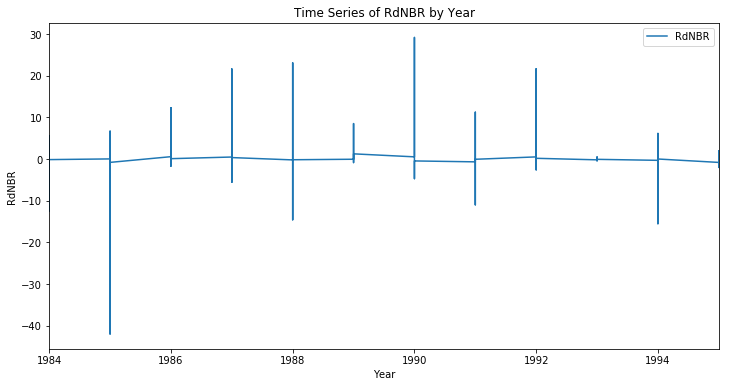

In [0]:
# df = df.sort_index()
#plt.figure(figsize=(10, 6))
#df['RdNBR'].plot();
df.plot(x='Year', y='RdNBR', figsize=(12,6))
plt.xlabel('Year')
plt.ylabel('RdNBR')
plt.title('Time Series of RdNBR by Year');

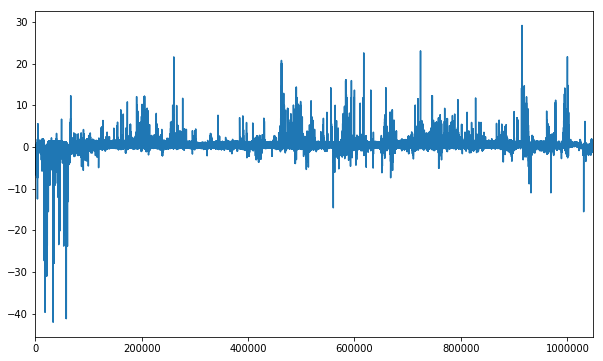

In [0]:
plt.figure(figsize=(10, 6))
df['RdNBR'].plot();

In [0]:
#split_date = pd.Timestamp('2018-01-01')
split_date = 700000

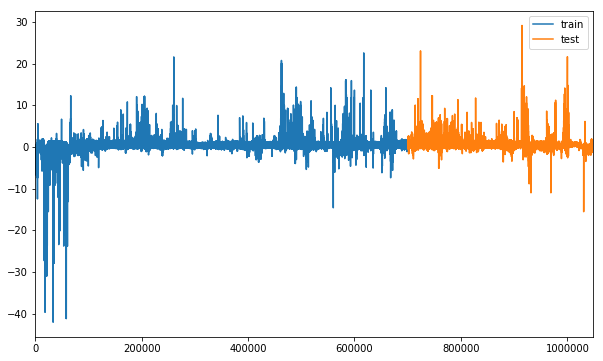

In [0]:
df =  df['RdNBR']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [0]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [0]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

# **NN**

In [0]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)







Epoch 1/100
700000/700000 [==============================] - 592s 846us/step - loss: 1.4553e-04
Epoch 2/100
700000/700000 [==============================] - 589s 842us/step - loss: 1.2964e-04
Epoch 3/100
700000/700000 [==============================] - 584s 834us/step - loss: 1.2843e-04
Epoch 4/100
700000/700000 [==============================] - 586s 837us/step - loss: 1.2774e-04
Epoch 5/100
700000/700000 [==============================] - 581s 830us/step - loss: 1.2750e-04
Epoch 6/100
700000/700000 [==============================] - 580s 829us/step - loss: 1.2726e-04
Epoch 7/100
700000/700000 [==============================] - 592s 846us/step - loss: 1.2735e-04
Epoch 8/100
700000/700000 [==============================] - 593s 847us/step - loss: 1.2718e-04
Epoch 9/100
700000/700000 [==============================] - 594s 849us/step - loss: 1.2712e-04
Epoch 10/100
700000/700000 [==============================] - 598s 854us/step - loss: 1.2695e-04
Epoch 11/100
700000/700000 [=====

In [0]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.358
The R2 score on the Test set is:	0.531


# **LSTM**
When constructing LSTM (Long short-term memory), we will use pandas shift function that shifts the entire column by 1. In the below code snippet, we shifted the column down by 1. Then we will need to convert all our input variables to be represented in a 3D vector form.

In [0]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (700000, 1, 1)
Test shape:  (348574, 1, 1)


In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
700000/700000 [==============================] - 1452s 2ms/step - loss: 1.5107e-04
Epoch 2/100
700000/700000 [==============================] - 1435s 2ms/step - loss: 1.3499e-04
Epoch 3/100
700000/700000 [==============================] - 1416s 2ms/step - loss: 1.2927e-04
Epoch 4/100
700000/700000 [==============================] - 1411s 2ms/step - loss: 1.2843e-04
Epoch 5/100
700000/700000 [==============================] - 1408s 2ms/step - loss: 1.2763e-04
Epoch 6/100
700000/700000 [==============================] - 1432s 2ms/step - loss: 1.2711e-04
Epoch 7/100
700000/700000 [==============================] - 1413s 2ms/step - loss: 1.2685e-04
Epoch 8/100
700000/700000 [==============================] - 1437s 2ms/step - loss: 1.2677e-04
Epoch 9/100
700000/700000 [==============================] - 1436s 2ms/step - loss: 1.2660e-04
Epoch 10/100
700000/700000 [=======================

In [0]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.344
The R2 score on the Test set is:	0.561


In [0]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

348574/348574 [==============================] - 220s 631us/step
NN: 0.000145
LSTM: 0.000135


In [0]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

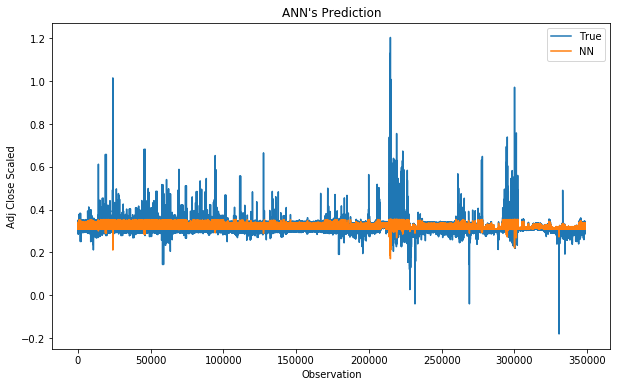

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

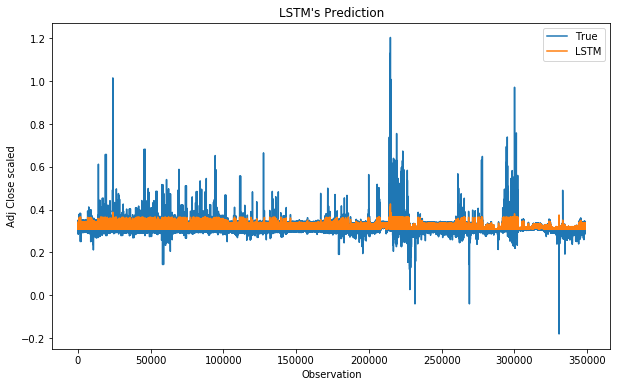

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();